In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#import janestreet
#env = janestreet.make_env() # initialize the environment

#!pip install datatable # Internet is not activated in this competition
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
import datatable as dt

import pickle
MODEL_FILE = '/kaggle/working/model.pickle'
XGBOOST_MODEL_FILE = '/kaggle/working/model_xgboost.model'

XGBOOST_MODEL_INTERFACE = 'sklearn' # or 'xgboost'
#XGBOOST_MODEL_INTERFACE = 'xgboost' # or 'xgboost'

DF_FILE = '../input/jane-street-first-time-series-dataframe-save/dataframe.pickle'
LOAD_DF = False

CALCULATE_MACD = True

PREDICT_THRESHOLD = 0.5

TIMESERIES_SPLIT = True

DO_GRIDSEARCH = False

import xgboost as xgb
import gc

from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

INPUT_DIR = '/kaggle/input/jane-street-market-prediction/'

pd.set_option('display.max_rows', 500)

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


/kaggle/input/jane-street-first-time-series-dataframe-save/__results__.html
/kaggle/input/jane-street-first-time-series-dataframe-save/dataframe.pickle
/kaggle/input/jane-street-first-time-series-dataframe-save/__notebook__.ipynb
/kaggle/input/jane-street-first-time-series-dataframe-save/__output__.json
/kaggle/input/jane-street-first-time-series-dataframe-save/custom.css
/kaggle/input/rapids/rapids.0.16.0
/kaggle/input/rapids/rapids.0.17.0
/kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


Thanks to following notebooks :  
https://www.kaggle.com/drcapa/jane-street-market-prediction-starter-xgb/output?select=example_sample_submission.csv

# Load data alternative

CUDF

In [2]:
# CUDF
#import sys
#!cp ../input/rapids/rapids.0.15.0 /opt/conda/envs/rapids.tar.gz
#!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
#sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
#sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
#sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
#!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

#import cudf

In [3]:
#dtypes_tab = {"feature_"+str(i) : "float32" for i in range(1,130)}
#dtypes_tab['feature_0'] = 'int8'

In [4]:
#df = cudf.read_csv('../input/jane-street-market-prediction/train.csv', dtypes=dtypes_tab)

In [5]:
#df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

DASK

In [6]:
# DASK

#import dask.dataframe as dd

#dtypes = {"feature_"+str(i) : "float32" for i in range(1,130)}
#dtypes['feature_0'] = 'int8'

#df = dd.read_csv('../input/jane-street-market-prediction/train.csv')

#print(df.shape)
#df.head()

# Load data

In [7]:
%%time
#dtypes = {"feature_"+str(i) : "float32" for i in range(1,130)}
#dtypes['feature_0'] = 'int8'

if (LOAD_DF != True):
    # Thanks to his notebook for this fast loading : https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance
    train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')
    df = train_data_datatable.to_pandas()

    # Thanks to this notebook to gain memory usage : https://www.kaggle.com/jorijnsmit/one-liner-to-halve-your-memory-usage
    float64_cols = df.select_dtypes(include='float64').columns
    mapper = {col_name: np.float32 for col_name in float64_cols}
    mapper['feature_0'] = 'int8'
    df = df.astype(mapper)
    
    del train_data_datatable
    
    df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict
    
    # Temporal features
    
    if (CALCULATE_MACD == True):
        #FEATURES_FOR_MACD = ['feature_'+str(i) for i in range(1,130)]
        FEATURES_FOR_MACD = ['feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45']

        for feature in FEATURES_FOR_MACD:
            #df.loc[:, feature + '_macd'] = df[feature].ewm(span=12, adjust=False).mean().astype('float32') # Short term exponential moving average\
            #- df[feature].ewm(span=26, adjust=False).mean().astype('float32') # Long term exponential moving average
            
            macd_feature = df[feature].ewm(span=12, adjust=False).mean().astype('float32') # Short term exponential moving average\
            - df[feature].ewm(span=26, adjust=False).mean().astype('float32') # Long term exponential moving average

            # We calculate MACD (which is short term EWMA (span 12) minus long term EWMA (span 26)) minus signal (which is MACD EWMA span 9)
            df.loc[:, feature + '_macd_minus_signal'] = macd_feature - macd_feature.ewm(span=9, adjust=False).mean().astype('float32')
            
            del macd_feature
            gc.collect()
    
else:
    with open(DF_FILE, 'rb') as f:
        df = pickle.load(f)   

CPU times: user 30.8 s, sys: 12.6 s, total: 43.4 s
Wall time: 1min 16s


In [8]:
df.dtypes

date                              int32
weight                          float32
resp_1                          float32
resp_2                          float32
resp_3                          float32
resp_4                          float32
resp                            float32
feature_0                          int8
feature_1                       float32
feature_2                       float32
feature_3                       float32
feature_4                       float32
feature_5                       float32
feature_6                       float32
feature_7                       float32
feature_8                       float32
feature_9                       float32
feature_10                      float32
feature_11                      float32
feature_12                      float32
feature_13                      float32
feature_14                      float32
feature_15                      float32
feature_16                      float32
feature_17                      float32


With (CALCULATE_MACD == True) : at this point, free RAM = 3.9 Gb

In [9]:
df['resp'].sum()

976.0646

# Remove first half of the data

In [10]:
#df.drop(index=df[df['date'] <= 249].index, inplace=True)

In [11]:
df.shape

(2390491, 144)

In [12]:
if (CALCULATE_MACD == True):
    FEATURES_MACD = [feat + '_macd_minus_signal' for feat in FEATURES_FOR_MACD]

    #for feature in FEATURES_FOR_MACD:
    #    df.loc[:, feature + '_macd_minus_signal_sup0']  = ((df.loc[:, feature + '_macd_minus_signal'] > 0) * 1).astype(np.byte)

In [13]:
#if (CALCULATE_MACD == True):
    #FEATURES_TODROP = ['feature_'+str(i)+'_macd' for i in range(1, 130)] + ['feature_'+str(i)+'_macd_minus_signal' for i in range(1,130)]
#    FEATURES_TODROP = ['feature_'+str(i)+'_macd' for i in range(1, 130)]

In [14]:
#if (CALCULATE_MACD == True):
#    #df.drop(FEATURES_TODROP, axis=1,inplace=True)
#    pass

In [15]:
#df[df['resp'] > 0].shape

In [16]:
gc.collect()

180

## Drop of 0 weights

In [17]:
#df.drop(df[df['weight'] == 0].index, axis=0, inplace=True)
#df.reset_index(drop=True, inplace=True)

In [18]:
df.shape

(2390491, 144)

In [19]:
#df[(df['resp'] > 0) & (df['resp_1'] > 0) & (df['resp_2'] > 0) & (df['resp_3'] > 0) & (df['resp_4'] > 0)].shape

In [20]:
#df.loc[:, 'resp_all_positive'] =  ((df['resp'] > 0) & (df['resp_1'] > 0) & (df['resp_2'] > 0) & (df['resp_3'] > 0) & (df['resp_4'] > 0))*1

# Drop features related to resp_1,2,3,4 (and not to resp)
Insight from notebook https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance  
Commented because this does not improve performance

In [21]:
#FEATURES_INDICE_TODROP = [7, 8, 17, 18, 27, 28, 55, 72, 78, 84, 90, 96, 102, 108, 114, 120, 121,
#11, 12, 21, 22, 31, 32, 57, 74, 80, 86, 92, 98, 104, 110, 116, 124, 125,
#13, 14, 23, 24, 33, 34, 58, 75, 81, 87, 93, 99, 105, 111, 117, 126,127,
#9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, 123,]

#FEATURES_TODROP = ['feature_'+str(feat) for feat in FEATURES_INDICE_TODROP]

In [22]:
#df.drop(columns=FEATURES_TODROP, axis=1, inplace=True)

# Split train test

In [23]:
df.shape

(2390491, 144)

In [24]:
if (TIMESERIES_SPLIT == False):
    train_size = int(df.shape[0] * 0.90)
    print(train_size)
    display(df.iloc[0:train_size-1, :])

In [25]:
if (TIMESERIES_SPLIT == False):
    df_train = df.iloc[0:train_size-1, :].copy(deep=True)
    y_train = df.iloc[0:train_size-1]['resp_positive'].copy(deep=True)
    #y_train = df.iloc[0:train_size-1]['resp_all_positive'].copy(deep=True)

    df_test = df.iloc[train_size:df.shape[0]-1].copy(deep=True) # This will be used for training steps
    df_test_origin = df_test.copy(deep=True) # We keep this for utility function
    y_test = df.iloc[train_size:df.shape[0]-1]['resp_positive'].copy(deep=True)
    #y_test = df.iloc[train_size:df.shape[0]-1]['resp_all_positive'].copy(deep=True)
    
else:
    tscv = TimeSeriesSplit(n_splits=10)

    for (train_index, test_index) in tscv.split(df):
        pass

    df_train, df_test = df.loc[train_index], df.loc[test_index]
    y_train, y_test = df.loc[train_index]['resp_positive'], df.loc[test_index]['resp_positive']
    
    df_test_origin = df_test.copy(deep=True) # We keep this for utility function
    
    print(df_train.shape)
    print(df_test.shape)
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

(2173174, 144)
(217317, 144)


In [26]:
del df
gc.collect()

20

In [27]:
df_train['resp'].sum()

817.8456

In [28]:
df_test['resp'].sum()

158.21907

In [29]:
df_train['feature_1'].sum()

852591.6

In [30]:
df_train.drop(['date', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'resp_positive', 'ts_id'], axis=1,inplace=True)
#df_train.drop(['date', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'resp_positive', 'resp_all_positive', 'ts_id'], axis=1,inplace=True)

In [31]:
df_test.drop(['date', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'resp_positive', 'ts_id'], axis=1,inplace=True)
#df_test.drop(['date', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'resp_positive', 'resp_all_positive', 'ts_id'], axis=1,inplace=True)

In [32]:
list(df_train.columns)

['weight',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature

In [33]:
df_test.shape

(217317, 136)

In [34]:
df_train.shape[0] + df_test.shape[0]

2390491

In [35]:
'''
tscv = TimeSeriesSplit(n_splits=10)

for (train_index, test_index) in tscv.split(df):
    pass

df_train, df_test = df.loc[train_index], df.loc[test_index]
y_train, y_test = df.loc[train_index]['resp_positive'], df.loc[test_index]['resp_positive']
'''

"\ntscv = TimeSeriesSplit(n_splits=10)\n\nfor (train_index, test_index) in tscv.split(df):\n    pass\n\ndf_train, df_test = df.loc[train_index], df.loc[test_index]\ny_train, y_test = df.loc[train_index]['resp_positive'], df.loc[test_index]['resp_positive']\n"

In [36]:
df_train.index

RangeIndex(start=0, stop=2173174, step=1)

In [37]:
df_test.index

RangeIndex(start=0, stop=217317, step=1)

In [38]:
#df_test.reset_index(drop=True, inplace=True)

In [39]:
#df_train.reset_index(drop=True, inplace=True)

In [40]:
gc.collect()

280

With (CALCULATE_MACD == True) : at this point, free RAM = 3.1 Gb

# Data clean

## Remove outliers

In [41]:
#df_train_bck = df_train.copy(deep=True)

In [42]:
df_train.shape

(2173174, 136)

In [43]:
#df_train[(df_train['feature_1'] < df_train.feature_1.quantile(0.001)) | (df_train['feature_1'] > df_train.feature_1.quantile(0.999))].shape

In [44]:
#low_quantile_to_remove = 0.0001
#high_quantile_to_remove = 1 - low_quantile_to_remove

In [45]:
#for feat in ['feature_'+str(i) for i in range(1,130)]:
#    index_to_drop = df_train[(df_train[feat] < df_train[feat].quantile(low_quantile_to_remove)) | (df_train[feat] > df_train[feat].quantile(high_quantile_to_remove))].index
#    df_train.drop(index=index_to_drop, axis=0, inplace=True)
#    y_train.drop(index=index_to_drop, axis=0, inplace=True)

In [46]:
#df_train.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)

In [47]:
df_train.shape

(2173174, 136)

In [48]:
y_train.shape

(2173174,)

In [49]:
#df_train = df_train_bck

In [50]:
# This was tested and worsen performances, so commented out for now

# Thanks to : https://www.kaggle.com/blurredmachine/jane-street-market-eda-viz-prediction

#threshold = 4

#z = np.abs(stats.zscore(df_train, nan_policy='omit'))
#print(f"Z score array:\n{z}")
#print('-'*30)

#row_index = np.where(z > threshold)
#print(f"Outlier Data Rows: {len(set(row_index[0]))}")
#print('-'*30)

#print(f"Outlier Rows Index:\n{row_index}")
#print('-'*30)

#print(f"Sample outlier row data:\n{z[row_index[0][0]]}")

#print(df_train.shape)
#print(df_train[(z < 5000).all(axis=1)].reset_index(drop=True).shape)
#df_train = df_train[(z < threshold).all(axis=1)].reset_index(drop=True)
#y_train = y_train[(z < threshold).all(axis=1)].reset_index(drop=True)
#print(df_train.shape)

#del z
#del row_index
#gc.collect()

## Remove missing (commented, because handled automatically by xgboost)

In [51]:
#cols_with_missing_train = [col for col in df_train.columns if df_train[col].isnull().any()]

In [52]:
# Finally we do not remove null values and let xgboost handle them (provides better performance)
#for col in cols_with_missing_train:
#    df_train[col].fillna(-999, inplace=True) 

In [53]:
#df_medians = df_train[cols_with_missing_train].median()
#df_train.loc[:, cols_with_missing_train].fillna(df_medians, inplace=True)

#Commented for now (handled by xgboost)
#df_train.fillna({col:-999 for col in cols_with_missing_train}, inplace=True) 

In [54]:
# Finally we do not remove null values and let xgboost handle them (provides better performance)
#for col in cols_with_missing_train:
#    df_test[col].fillna(-999, inplace=True) 

In [55]:
#df_test.loc[:, cols_with_missing_train].fillna(df_medians, inplace=True)

#Commented for now (handled by xgboost)
#df_test.fillna({col:-999 for col in cols_with_missing_train}, inplace=True) 

In [56]:
gc.collect()

320

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173174 entries, 0 to 2173173
Columns: 136 entries, weight to feature_45_macd_minus_signal
dtypes: float32(135), int8(1)
memory usage: 1.1 GB


In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217317 entries, 0 to 217316
Columns: 136 entries, weight to feature_45_macd_minus_signal
dtypes: float32(135), int8(1)
memory usage: 112.1 MB


## Example with feature 1

In [59]:
'''
df_train_subsample = df_train.loc[2000:2020, :]

exp1 = df_train_subsample['feature_1'].ewm(span=12, adjust=False).mean() # Short term exponential moving average
exp2 = df_train_subsample['feature_1'].ewm(span=26, adjust=False).mean() # Long term exponential moving average

macd = exp1 - exp2

exp3 = macd.ewm(span=9, adjust=False).mean() # Signal line
resp = df_train_subsample['resp'] * df_train_subsample['feature_1'].mean() / np.abs(df_train_subsample['resp'].mean()) # Resp augmented to fit mean of feature 1 for better visualisation



plt.figure(figsize=(20,10))

plt.plot(df_train_subsample.ts_id, df_train_subsample.feature_1, label='Feature 1')
plt.plot(df_train_subsample.ts_id, macd, label='Feature 1 MACD', color='orange')
plt.plot(df_train_subsample.ts_id, exp3, label='Signal Line', color='Magenta')
plt.plot(df_train_subsample.ts_id, resp, label='Resp', color='red')
plt.legend(loc='upper left')
plt.show()
'''

"\ndf_train_subsample = df_train.loc[2000:2020, :]\n\nexp1 = df_train_subsample['feature_1'].ewm(span=12, adjust=False).mean() # Short term exponential moving average\nexp2 = df_train_subsample['feature_1'].ewm(span=26, adjust=False).mean() # Long term exponential moving average\n\nmacd = exp1 - exp2\n\nexp3 = macd.ewm(span=9, adjust=False).mean() # Signal line\nresp = df_train_subsample['resp'] * df_train_subsample['feature_1'].mean() / np.abs(df_train_subsample['resp'].mean()) # Resp augmented to fit mean of feature 1 for better visualisation\n\n\n\nplt.figure(figsize=(20,10))\n\nplt.plot(df_train_subsample.ts_id, df_train_subsample.feature_1, label='Feature 1')\nplt.plot(df_train_subsample.ts_id, macd, label='Feature 1 MACD', color='orange')\nplt.plot(df_train_subsample.ts_id, exp3, label='Signal Line', color='Magenta')\nplt.plot(df_train_subsample.ts_id, resp, label='Resp', color='red')\nplt.legend(loc='upper left')\nplt.show()\n"

# Feature definition

In [60]:
FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)] + ['weight']
#FEATURES_LIST_TOTRAIN = [feat for feat in FEATURES_LIST_TOTRAIN if feat not in FEATURES_TODROP]

if (CALCULATE_MACD == True):
    #FEATURES_LIST_TOTRAIN.extend(['feature_'+str(i)+'_macd_minus_signal' for i in range(1,130)])  
    FEATURES_LIST_TOTRAIN.extend(FEATURES_MACD)  

In [61]:
len(FEATURES_LIST_TOTRAIN)

136

In [62]:
#FEATURES_LIST = ['feature_'+str(i) for i in range(130)] + ['feature_'+str(i)+'_macd' for i in range(1, 130)] + ['feature_'+str(i)+'_macd_minus_signal' for i in range(1,130)]+  ['weight']

In [63]:
#df[FEATURES_LIST]

# Utility calculation function

In [64]:
def utility_function(df_test, df_test_predictions):
    df_test.loc[:, 'utility_pj'] = df_test['weight'] * df_test['resp'] * df_test_predictions
    df_test_utility_pi = df_test.groupby('date').sum('utility_pj')['utility_pj']
    nb_unique_dates = df_test_utility_pi.shape[0]
    t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))
    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    
    return(u)

# Train model

In [65]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    params = {

        'random_state' : 42,
        'max_depth': 12,
        #'max_depth': 50,
        #'learning_rate': 0.05,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.2,
        'tree_method': 'gpu_hist',
        'seed': 42,
        'objective' : "binary:logistic",
        #"disable_default_eval_metric": 1,
    }

In [66]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    d_train = xgb.DMatrix(df_train, label=y_train) #missing = ?

In [67]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    del df_train
    gc.collect()

In [68]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    d_test = xgb.DMatrix(df_test, label=y_test)

In [69]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    del df_test
    gc.collect()

In [70]:
from sklearn.metrics import brier_score_loss
#brier_score_loss(y_true, y_prob)

#def brier_score_custom(predt: np.ndarray, dtrain: xgb.DMatrix):
def brier_score_custom(y_pred_scores, y_true):
    probas = 1/(1+np.exp(-y_pred_scores)) # y_pred_scores 
    #print(probas)
    #print(y_true.get_label())
    #print(probas - y_true.get_label())
    #print('*************')
    
    #print(y_pred_scores)
    #print(y_true.get_label())
    brier_score = brier_score_loss(y_true.get_label(), probas)
    #print(brier_score)
    
    return('brier_loss', brier_score)

In [71]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    model = XGBClassifier(
    random_state= 42,
    max_depth= 12,
    n_estimators= 500,
    learning_rate= 0.01,
    subsample= 0.9,
    colsample_bytree= 0.2,
    tree_method= 'gpu_hist',
    objective= 'binary:logistic',
    disable_default_eval_metric=True,
    )

'''
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    model = XGBClassifier(
    random_state= 42,
    max_depth= 12,
    n_estimators= 500,
    learning_rate= 0.05,
    subsample= 0.9,
    colsample_bytree= 0.7,
    tree_method= 'gpu_hist',
    #objective= 'binary:logistic',
    verbosity=3
    )
'''

"\nif (XGBOOST_MODEL_INTERFACE == 'sklearn'):\n    model = XGBClassifier(\n    random_state= 42,\n    max_depth= 12,\n    n_estimators= 500,\n    learning_rate= 0.05,\n    subsample= 0.9,\n    colsample_bytree= 0.7,\n    tree_method= 'gpu_hist',\n    #objective= 'binary:logistic',\n    verbosity=3\n    )\n"

In [72]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    display(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.2,
              disable_default_eval_metric=True, gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=12,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.9, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)

In [73]:
%%time
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    #FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)] + ['weight']
        
    if (DO_GRIDSEARCH == True):
        param_search = { 'random_state': [42],
                 'max_depth': [12],
                 'n_estimators': [500],
                'learning_rate': [0.01],
                'subsample': [0.9],
                'colsample_bytree': [0.2],
                 'tree_method': ['gpu_hist'],
               }
        
        model = XGBClassifier()
        
        tscv_subsplits = TimeSeriesSplit(n_splits=3)

        grid_search = GridSearchCV(estimator=model, cv=tscv_subsplits,
                        param_grid=param_search, verbose=10)

        grid_search.fit(df_train[FEATURES_LIST_TOTRAIN], y_train)
        
        model = grid_search.best_estimator_
        
    
    else:
        model.fit(df_train[FEATURES_LIST_TOTRAIN], y_train, verbose=True)
        
        #model.fit(df_train, y_train, verbose=True)
        
        
        #model.fit(df_train, y_train, verbose=True, eval_metric=brier_score_custom)
        #model.fit(df_train, y_train, early_stopping_rounds=10, verbose=True, eval_metric=brier_score_custom)

CPU times: user 1min 54s, sys: 3.92 s, total: 1min 58s
Wall time: 1min 59s


learning rate 0.1, max depth 12, subsample 0.9, colsample by tree 0.2, learning rate 0.01 SANS FEATURES MACD, AVEC tout le training set, et pas d'eval set, interface scikit learn :    
=> utility score 2137 avec threshold 0.504

In [74]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              disable_default_eval_metric=True, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [75]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    display(model.feature_importances_)

array([0.02108393, 0.00529111, 0.00524878, 0.0105522 , 0.00975915,
       0.01199412, 0.01172362, 0.0069661 , 0.00723553, 0.0053649 ,
       0.00584201, 0.00567012, 0.0056349 , 0.00499247, 0.00499258,
       0.00489232, 0.00521327, 0.00661157, 0.00679116, 0.00573015,
       0.0070207 , 0.00612877, 0.00597715, 0.00593979, 0.00599497,
       0.00567504, 0.00586502, 0.01057341, 0.00863525, 0.00610141,
       0.00593845, 0.00735307, 0.00613351, 0.00641347, 0.00565889,
       0.00581225, 0.00588356, 0.00939444, 0.00956941, 0.01140989,
       0.01005944, 0.01490975, 0.01432339, 0.01723089, 0.01408075,
       0.01432997, 0.00592081, 0.00615106, 0.00611293, 0.00589116,
       0.00621948, 0.00561847, 0.00515079, 0.00682618, 0.00583744,
       0.00913627, 0.00621453, 0.00768237, 0.00710585, 0.00629536,
       0.01216531, 0.01176249, 0.01272817, 0.01220947, 0.0085891 ,
       0.00707636, 0.00779124, 0.00757024, 0.00811189, 0.00768106,
       0.00712218, 0.00805327, 0.00649542, 0.00523262, 0.00531

In [76]:
    params = {

        'random_state' : 42,
        'max_depth': 12,
        #'max_depth': 50,
        #'learning_rate': 0.05,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.2,
        #'tree_method': 'gpu_hist',
        'seed': 42,
        'objective' : "binary:logistic",
        #"disable_default_eval_metric": 1,
    }

In [77]:
%%time
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    #watchlist = [(d_train, 'train'), (d_test, 'valid')]
    # A essayer : pas de watchlist (on va d'abord essayer avec le wrapper scikit learn)
    #model = xgb.train(dtrain=d_train, early_stopping_rounds=10, verbose_eval=1000, params=params, num_boost_round=500, feval=brier_score_custom, maximize=False)
    #model = xgb.train(dtrain=d_train, verbose_eval=1000, params=params, num_boost_round=500, feval=brier_score_custom, maximize=False)
    model = xgb.train(dtrain=d_train, verbose_eval=1000, params=params, num_boost_round=500)

    #model = xgb.train(dtrain=d_train, evals=watchlist, early_stopping_rounds=10, verbose_eval=1000, params=params, num_boost_round=500, feval=brier_score_custom, maximize=False)


    #model = xgb.train(dtrain=d_train, evals=watchlist, early_stopping_rounds=10, verbose_eval=1000, params=params, num_boost_round=500)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


Stopping. Best iteration:  
[37]	train-rmse:0.48218	valid-rmse:0.49920  

With just basic features and weight :  
[13]	train-error:0.40596	valid-error:0.47772 

With just basic features and weight, but prediction on all resp positive :
[5]	train-error:0.25558	valid-error:0.26560

With max depth 50 :  
[0]	train-brier_loss:0.23657	valid-brier_loss:0.25021  

learning rate 0.1, max depth 20 :  
[19]	train-brier_loss:0.23434	valid-brier_loss:0.24996

learning rate 0.1, max depth 12 :  
[19]	train-brier_loss:0.23434	valid-brier_loss:0.24930  


learning rate 0.1, max depth 12, num_boost_round=1000 (au lieu de 500) :  
[19]	train-brier_loss:0.23434	valid-brier_loss:0.24930  => sûrement le early stopping


learning rate 0.1, max depth 12, subsample 0.7 :  
[15]	train-brier_loss:0.23684	valid-brier_loss:0.24923

learning rate 0.1, max depth 12, subsample 0.7, learning rate 0.05 :  
[40]	train-brier_loss:0.23427	valid-brier_loss:0.24905

learning rate 0.1, max depth 12, subsample 0.5, learning rate 0.05 :    
[44]	train-brier_loss:0.23404	valid-brier_loss:0.24900

learning rate 0.1, max depth 12, subsample 0.5, learning rate 0.02 :   
[96]	train-brier_loss:0.23530	valid-brier_loss:0.24882 => utility score 2035.28

learning rate 0.1, max depth 12, subsample 0.5, colsample by tree 0.2, learning rate 0.02 :   
[156]	train-brier_loss:0.23395	valid-brier_loss:0.24877  => utility score 2162.89

learning rate 0.1, max depth 12, subsample 0.9, colsample by tree 0.2, learning rate 0.02 :   
[143]	train-brier_loss:0.23329	valid-brier_loss:0.24862 => utility score 2187.13

learning rate 0.1, max depth 12, subsample 0.9, colsample by tree 0.2, learning rate 0.01 :   
[327]	train-brier_loss:0.23182	valid-brier_loss:0.24859 => utility score 2191 => 2214.06 avec threshold 0.503   => BEST
     
learning rate 0.1, max depth 12, subsample 0.9, colsample by tree 0.2, learning rate 0.01 ET FEATURES MACD, AVEC la moitié du training set :  
[265]	train-brier_loss:0.22946	valid-brier_loss:0.24851  => utility score 1480.29 avec threshold 0.503

learning rate 0.1, max depth 12, subsample 0.9, colsample by tree 0.2, learning rate 0.01 SANS FEATURES MACD, AVEC la moitié du training set :  
[286]	train-brier_loss:0.22920	valid-brier_loss:0.24832  => utility score 1423 avec threshold 0.503 

In [78]:
'''
# This part uses scikit learn wrapper
%%time
#tscv_subsplits = TimeSeriesSplit(n_splits=2)

#grid_search = GridSearchCV(estimator=model, cv=tscv_subsplits,
#                        param_grid=param_search, verbose=10)

#grid_search.fit(df_train[FEATURES_LIST], y_train)

model = xgb.XGBClassifier(random_state=42, max_depth=12, n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, missing=-999, verbose=10, tree_method = 'gpu_hist')
#model = xgb.XGBClassifier(random_state=42, max_depth=12, n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, missing=-999, verbose=10)

#model.fit(df_train[FEATURES_LIST], y_train)
model.fit(df_train, y_train, early_stopping_rounds=10,  eval_set=[(df_test, y_test)])

#model = grid_search
'''

"\n# This part uses scikit learn wrapper\n%%time\n#tscv_subsplits = TimeSeriesSplit(n_splits=2)\n\n#grid_search = GridSearchCV(estimator=model, cv=tscv_subsplits,\n#                        param_grid=param_search, verbose=10)\n\n#grid_search.fit(df_train[FEATURES_LIST], y_train)\n\nmodel = xgb.XGBClassifier(random_state=42, max_depth=12, n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, missing=-999, verbose=10, tree_method = 'gpu_hist')\n#model = xgb.XGBClassifier(random_state=42, max_depth=12, n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, missing=-999, verbose=10)\n\n#model.fit(df_train[FEATURES_LIST], y_train)\nmodel.fit(df_train, y_train, early_stopping_rounds=10,  eval_set=[(df_test, y_test)])\n\n#model = grid_search\n"

In [79]:
print('Model training ended')

Model training ended


In [80]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    model.save_model(XGBOOST_MODEL_FILE)

In [81]:
#model.best_estimator_

In [82]:
#model.best_estimator_.feature_importances_

In [83]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    df_gains = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient='index', columns=['gain']).sort_values(by='gain', ascending=False)

In [84]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    df_gains_cumulated = pd.concat([df_gains, pd.DataFrame({'% Gain cumulé' : (df_gains['gain'] / df_gains['gain'].sum()).cumsum()})], axis=1)

In [85]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    df_gains_cumulated['% Gain cumulé'].plot.bar()

In [86]:
#model.feature_importances_

# Save model

In [87]:
print('Saving model')

Saving model


In [88]:
with open(MODEL_FILE, 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [89]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    model.save_model(XGBOOST_MODEL_FILE)

In [90]:
!ls -l

total 64276
---------- 1 root root   129226 Dec 16 14:32 __notebook__.ipynb
-rw-r--r-- 1 root root 65687144 Dec 16 14:32 model.pickle


In [91]:
'''
df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
'''

'\ndf_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)\ndf_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)\ndf_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)\ndf_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)\n'

In [92]:
#df_grid_search_results

# Test predictions

In [93]:
print('Testing predictions')

Testing predictions


In [94]:
PREDICT_THRESHOLD = 0.5
#PREDICT_THRESHOLD = 0.5

In [95]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    #df_test_predictions = (pd.Series([p[1] for p in model.predict_proba(df_test)]) > PREDICT_THRESHOLD).astype(np.byte)
    
    df_test_predictions = (pd.Series([p[1] for p in model.predict_proba(df_test[FEATURES_LIST_TOTRAIN])]) > PREDICT_THRESHOLD).astype(np.byte)
    
    
else:
    df_test_predictions = (pd.Series(model.predict(d_test)) > PREDICT_THRESHOLD).astype(np.byte)

In [96]:
df_test_predictions

0         1
1         0
2         0
3         1
4         1
         ..
217312    0
217313    0
217314    0
217315    1
217316    0
Length: 217317, dtype: int8

In [97]:
df_test_origin.reset_index(drop=True, inplace=True)

In [98]:
df_test_origin.shape

(217317, 144)

In [99]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    #df_test_predictions = model.predict(df_test[FEATURES_LIST])
    test_predictions = model.predict(d_test)

In [100]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    test_predictions

In [101]:
print('Calculating utility score')

Calculating utility score


In [102]:
utility_score = utility_function(df_test_origin, df_test_predictions)

In [103]:
utility_score

2174.5751953125

Utility score avec les features macd et macd - minus signal et threshold 0.5001: 1217.0041  
Utility score avec juste les features de base et threshold 0.5001: 1269.3579711914062  
Utility score avec juste les features de base et threshold 0.5001 et y_train portant sur *tous* les resp positifs : 2.67  
Utility score avec juste les features de base et threshold 0.5001, erreur RMSE: 1294.3004150390625

In [104]:
print('Calculating accuracy score')

Calculating accuracy score


In [105]:
accuracy_score(y_test, df_test_predictions)

0.5279108399250864

In [106]:
THRESHOLD_LIST = [0.5, 0.5001, 0.5005, 0.501, 0.51, 0.52, 0.53, 0.54]

if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    df_test_predictions_tab = [(pd.Series([p[1] for p in model.predict_proba(df_test[FEATURES_LIST_TOTRAIN])]) > threshold).astype(np.byte) for threshold in THRESHOLD_LIST]
    utility_score_tab = [utility_function(df_test_origin, df_test_predictions_series) for df_test_predictions_series in df_test_predictions_tab]

In [107]:
utility_score_tab

[2174.5751953125,
 2172.3603515625,
 2171.5623779296875,
 2151.908935546875,
 1981.390869140625,
 1666.1438598632812,
 1402.1699523925781,
 1122.6982727050781]

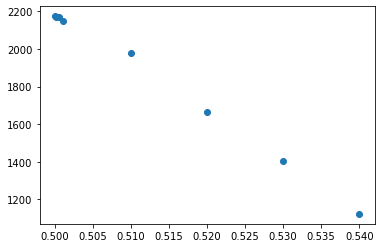

In [108]:
plt.scatter(THRESHOLD_LIST, utility_score_tab)

# Analyse model results

In [109]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    #df_featimportance = pd.DataFrame(model.feature_importances_, index=df_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance = pd.DataFrame(model.feature_importances_, index=df_train[FEATURES_LIST_TOTRAIN].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)

In [110]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    display(df_featimportance_cumulated)

,Importance,% feat importance cumulé
feature_0,0.021084,0.021084
feature_43,0.017231,0.038315
feature_41,0.014910,0.053225
feature_45,0.014330,0.067555
feature_42,0.014323,0.081878
feature_44,0.014081,0.095959
feature_62,0.012728,0.108687
feature_63,0.012209,0.120896
feature_60,0.012165,0.133062
feature_5,0.011994,0.145056


In [111]:
if (XGBOOST_MODEL_INTERFACE == 'sklearn'):
    display(df_featimportance_cumulated)

,Importance,% feat importance cumulé
feature_0,0.021084,0.021084
feature_43,0.017231,0.038315
feature_41,0.014910,0.053225
feature_45,0.014330,0.067555
feature_42,0.014323,0.081878
feature_44,0.014081,0.095959
feature_62,0.012728,0.108687
feature_63,0.012209,0.120896
feature_60,0.012165,0.133062
feature_5,0.011994,0.145056


In [112]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    df_gains_cumulated = pd.concat([df_gains, pd.DataFrame({'% Gain cumulé' : (df_gains['gain'] / df_gains['gain'].sum()).cumsum()})], axis=1)

In [113]:
if (XGBOOST_MODEL_INTERFACE == 'xgboost'):
    display(df_gains_cumulated)

In [114]:
df_gains_cumulated

NameError: name 'df_gains_cumulated' is not defined